# EV charging station Milano

In [253]:
import geopandas as gpd
import fiona
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time

In [254]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

chromedrive_path = os.path.join(os.getcwd(),"airbnb_scraper","chromedriver") # use the path to the driver you downloaded from previous steps
chrome_executable = Service(executable_path=chromedrive_path , log_path='NUL')
driver = webdriver.Chrome(service=chrome_executable)

In [255]:
df = gpd.read_file('ds964_nil_wm.geojson')
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [256]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ID_NIL        88 non-null     int64   
 1   NIL           88 non-null     object  
 2   Valido_dal    88 non-null     object  
 3   Valido_al     88 non-null     object  
 4   Fonte         88 non-null     object  
 5   Shape_Length  88 non-null     float64 
 6   Shape_Area    88 non-null     float64 
 7   OBJECTID      88 non-null     int64   
 8   geometry      88 non-null     geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 6.3+ KB


In [257]:
xc,yc = [],[]
for n,g in zip(df['NIL'],df['geometry']):
    xc.append(g.centroid.x)
    yc.append(g.centroid.y)
df['xc'] = xc
df['yc'] = yc

In [258]:
df.head()

,ID_NIL,NIL,Valido_dal,Valido_al,Fonte,Shape_Length,Shape_Area,OBJECTID,geometry,xc,yc
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,8723.368714,2.406306e+06,89,"POLYGON ((9.15422 45.43775, 9.15274 45.43887, ...",9.137260,45.438460
1,64,TRENNO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3309.998800,4.896921e+05,90,"POLYGON ((9.10623 45.49016, 9.10591 45.49084, ...",9.101675,45.492822
2,67,PORTELLO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3800.750663,9.096022e+05,91,"POLYGON ((9.15636 45.48785, 9.15495 45.48852, ...",9.153947,45.484490
3,81,BOVISASCA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7105.469715,1.578028e+06,92,"POLYGON ((9.16803 45.52234, 9.16763 45.52272, ...",9.156731,45.517433
4,84,PARCO NORD,05/02/2020,Vigente,Milano 2030 - PGT Approvato,11741.717005,1.532331e+06,93,"POLYGON ((9.20040 45.52848, 9.20028 45.52846, ...",9.184235,45.523514


In [259]:
def get_url_centroid(x,y):
    
    url_front = 'https://www.google.it/maps/search/stazioni+di+ricarica+auto+elettriche/@'
    url_coord = str(y)+','+str(x)
    url_back = ',17z/data=!3m1!4b1'
    url = url_front+url_coord+url_back
    
    return url

In [279]:
def return_list(url):
    
    driver.get(url)
    wait = WebDriverWait(driver,5)
    
    try:
        x_path_easy   = "//*[@jstcache=""235""]"
        wait.until(EC.presence_of_all_elements_located((By.XPATH,x_path_easy)))
        soup_reviews = BeautifulSoup(driver.page_source, features="lxml")
        r_list = soup_reviews.findAll('div', {'jstcache': "235"})
    
    except:
        x_path_easy   = "//*[@jstcache=""248""]"
        wait.until(EC.presence_of_all_elements_located((By.XPATH,x_path_easy)))
        soup_reviews = BeautifulSoup(driver.page_source, features="lxml")
        r_list = soup_reviews.findAll('div', {'jstcache': "248"})
    
    if len(r_list) == 12:
        x_path_easy   = "//*[@jstcache=""252""]"
        wait.until(EC.presence_of_all_elements_located((By.XPATH,x_path_easy)))
        soup_reviews = BeautifulSoup(driver.page_source, features="lxml")
        r_list = soup_reviews.findAll('div', {'jstcache': "252"})

    return r_list

In [261]:
def get_address(r):
    
    list_exit = []
    for k in r.findAll('div', {'class': 'W4Efsd'}):
        for i in k.findAll('span'):
            string = i.text
            string = string.replace('·','')
            list_exit.append(string)

    if list_exit[12] == '':
        address = list_exit[15]
    else:
        address = list_exit[12]
    
    return address

In [262]:
 def get_cordinates_place(url_place):
    
    url_place = url_place.split('!')
    
    y = url_place[5]
    y = y.split('d')
    y = float(y[1])
    x = url_place[6]
    x = x.split('d')
    x = float(x[1])

    return x,y

In [280]:
data = []

for i in df.index:
    
    print(df.loc[i,'NIL'])
    url = get_url_centroid(df.loc[i,'xc'],df.loc[i,'yc'])
    r_list = return_list(url)
    
    for r in r_list:
        
        name = r.find('a').get('aria-label')
        location = get_address(r)
        url_place = r.find('a').get('href')
        
        x,y = get_cordinates_place(url_place)
        
        data.append(
            [
                name,
                location,
                x,
                y
            ],
        )
        
my_columns = ['name','location','x','y']
df_cs = pd.DataFrame(data = data,columns = my_columns)

RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO
TRENNO
PORTELLO
BOVISASCA
PARCO NORD
FIGINO
LORETO - CASORETTO - NOLO
QUARTO OGGIARO - VIALBA - MUSOCCO
ISOLA
QUARTO CAGNINO
STADIO - IPPODROMI
QUINTO ROMANO
DUOMO
GUASTALLA
SAN SIRO
COMASINA
TIBALDI
GRECO - SEGNANO
DE ANGELI - MONTE ROSA
FARINI
BRUZZANO
QT 8
STEPHENSON
CANTALUPA
QUINTOSOLE
PARCO SEMPIONE
BARONA
VILLAPIZZONE - CAGNOLA - BOLDINASCO
PARCO BOSCO IN CITTA'
GORLA - PRECOTTO
NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI
TRIULZO SUPERIORE
PTA ROMANA
TALIEDO - MORSENCHIO - Q.RE FORLANINI
PORTA TICINESE - CONCA DEL NAVIGLIO
TRE TORRI
ASSIANO
MORIVIONE
VIGENTINO - Q.RE FATIMA
BICOCCA
ORTOMERCATO
LODI - CORVETTO
MUGGIANO
PORTA TICINESE - CONCHETTA
UMBRIA - MOLISE - CALVAIRATE
ROSERIO
RONCHETTO DELLE RANE
Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO
MONLUE' - PONTE LAMBRO
PADOVA - TURRO - CRESCENZAGO
GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE
PORTA MAGENTA
FORZE ARMATE
GHISOLFA
CHIARAVALLE
PARCO DELLE ABBAZIE
MACI

In [281]:
df_cs = df_cs.drop_duplicates(subset=['x', 'y'])

In [294]:
df_cs.to_csv('ev_location.csv')

In [282]:
df_cs

,name,location,x,y
0,Eni Station,"Via Lodovico Il Moro, 187",9.126119,45.438949
1,Stazione di ricarica per veicolo elettrico,"Via, Via Menaggio",9.124977,45.446078
2,evway Stazione di Ricarica,"Via Giambellino, 31",9.149510,45.450786
3,Be Charge Stazione di Ricarica,"Via Carlo Bo, 11",9.163772,45.440407
4,Be Charge Stazione di Ricarica,"Via Val Bavona, 21",9.124148,45.448408
...,...,...,...,...
779,Enel X Stazione di Ricarica,"Via Cimitero, 6",9.240778,45.522728
780,Enel X Stazione di Ricarica,"Viale Rimembranze, 93",9.241065,45.529345
782,Enel X Stazione di Ricarica,"Via Fratelli di Dio, 18",9.250922,45.525637
783,Eni Station,"Via Angelo Inganni, 99",9.122395,45.456600


In [289]:
df_cs_geo = df_cs
df_cs_geo["geometry"] = gpd.points_from_xy(df_cs_geo["x"], df_cs_geo["y"])
df_cs_geo = gpd.GeoDataFrame(df_cs_geo, crs="epsg:4326")

In [287]:
df_cs_geo = df_cs_geo.to_crs(epsg = '4326')

In [284]:
strade = gpd.read_file(os.path.join(os.getcwd(),'DBT2012_STRATO01_E0(1)','L010107.shp'))
strade.crs

<Derived Projected CRS: EPSG:6707>
Name: RDN2008 / UTM zone 32N (N-E)
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Italy - onshore and offshore - west of 12°E.
- bounds: (5.94, 36.53, 12.0, 47.04)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: Rete Dinamica Nazionale 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [285]:
strade = strade.to_crs(epsg = '4326')

<AxesSubplot:>

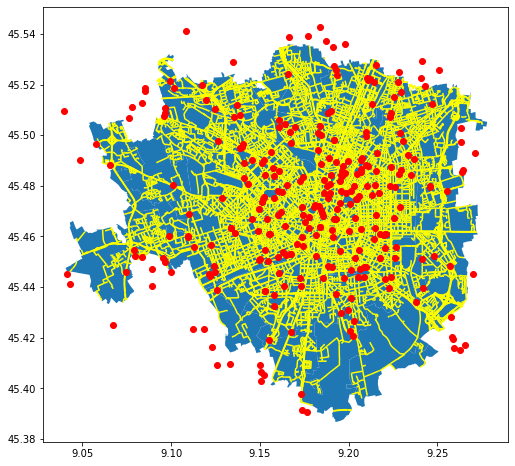

In [293]:
fig,ax = plt.subplots(figsize=(16,8))
df.plot(ax=ax)
strade.plot(ax=ax,color='yellow')
df_cs_geo.plot(ax=ax,color = 'red',zorder=3)

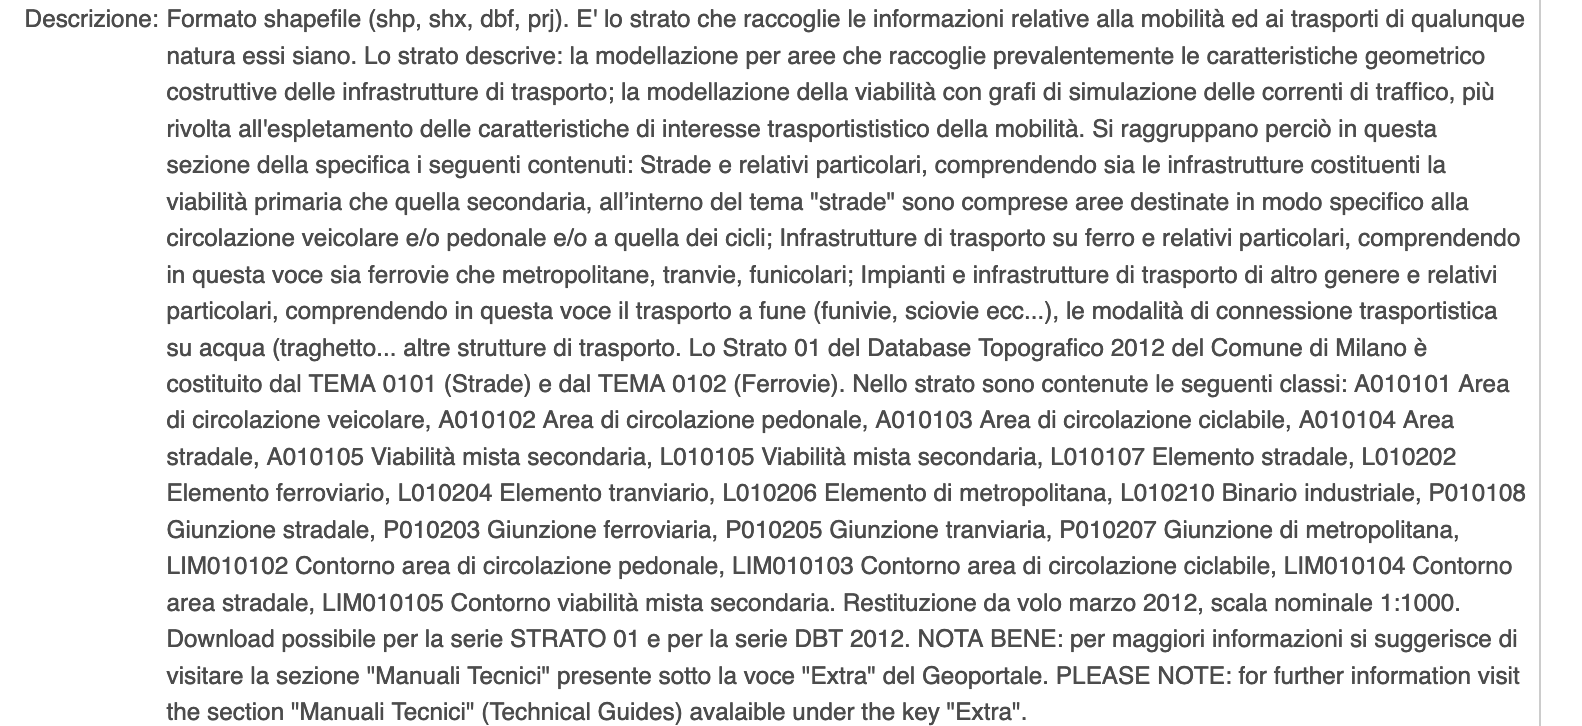